In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Suppress ta warnings
import warnings
warnings.filterwarnings("ignore")

# Auto reload local files
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Make files in src/ available to notebook
import sys
if '../src' not in sys.path:
    sys.path.insert(0, '../src')

In [2]:
from datetime import datetime, timedelta

# Read SPY csv, define config
watchlist = list(pd.read_csv('../data/watchlist.csv', header=0)['symbol'])
spy_constituents = list(pd.read_csv('../../data/spy_constituents.csv', header=0)['Symbol'])
random.shuffle(spy_constituents)

# Current tickers we have in database
tickers = ["AAL","AAP","AAPL","ACN","ADP","ADX","AEE","AEP","AFL","AIV","AJG","AKAM","ALGN","AMAT","AMD","AMN","AMP","AMT","ANSS","AON","AOS","ARA","ARE","ATGE","ATUS","AVGO","BA","BBWI","BCEI","BK","BKN","BKNG","BKR","BLK","BLL","BRK.B","BRO","BTC-USD","BYM","CAAP","CAT","CBRE","CBT","CELG~","CF","CHD","CHRW","CIA","CL","CMCSA","CMI","CMS","CNC","COF","COP","COST","CPRT","CRL","CSX","CTLT","CTRA","CTSH","CUZ","CYD","DD","DEI","DHR","DIS","DOV","DOW","DPW","DPZ","DRE","DRI","DRQ","DVA","DXC","DXCM","ECL","EFX","EL","ELC","EMR","ES","EVA","EXPD","EXR","FANG","FBHS","FE","FLT","FOX","FPAC","GE","GEF","GLW","GM","GNRC","GOOG","GPC","GPM","GPS","GWW","HAL","HD","HESM","HOLX","HOV","HPE","HPQ","HQL","HRI","HRL","HUBB","HUYA","ICE","INFO","INTC","IPG","IQV","IRM","ISD","ISRG","J","JCI","JDD","JNJ","KEY","KO","KRO","LEN","LH","LHX","LNC","LRCX","LTC-USD","LYV","MA","MAXR","MC","MCR","MDLZ","MEG","MLM","MMI","MMM","MO","MPC","MPWR","MRK","MRO","MSFT","MSGS","MTB","NAVB","NEM","NFJ","NLSN","NML","NNA","NOC","NRG","NTP","NVDA","NWS","NXRT","OKE","ORA","OTIS","PAYC","PCAR","PEAK","PENN","PHM","PHX","PLYM","PNR","PRU","PWR","PYS","QCOM","RCA","REGN","RF","RJF","ROST","RSG","SCHW","SEE","SLCA","SMLP","SOR","SPH","SRL","STE","SWK","SWKS","T","TAP","TDS","TDY","TECH","TEN","THO","TMO","TNK","TPR","TRMB","TSCO","TSLA","TT","TWTR","TXN","TXT","TYL","UDR","UNF","UNH","UPS","USB","V","VCIF","VFC","VMC","VNO","VRSK","VTI","VTR","WEC","WELL","WFC","WIT","WMB","WU","XOM","XPO","YUM","YUMC","ZBH","ZBRA","ZION","ZTS"]
start_date = pd.to_datetime("2022-06-01")
end_date = datetime.now() + timedelta(hours=3)
predict_window = 30  # = 2.5 hours

In [3]:
# Load the data from db
from sklearn.model_selection import train_test_split

import datastore as ds
from technical_signals import TechnicalSignalSet

#ds.download_candles(tickers, start_date, end_date)
def get_train_test(tickers, start_date, end_date):
    candlesticks = ds.get_candles(tickers, start_date, end_date, interval='5min')

    Xs = []
    ys = []

    for ticker in tickers:
        try:
            technical_sigs = TechnicalSignalSet(candlesticks[ticker], predict_window)
            X, y, Xy_date = technical_sigs.to_xy()
            Xs.append(X)
            ys.append(y)
        except Exception as ex:
            print(f"Exception on {ticker}:")
            print(ex)

    X = np.concatenate(Xs, axis=0)
    y = np.concatenate(ys, axis=0)

    return train_test_split(X, y, test_size=0.05)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import gc


def round_batch_size(sample_count, approximately, leeway=None):
    """
    Round batch size to a more suitable value. This helps to avoid a
    problem where the final batch has a lot of samples, but not enough for
    a full batch, leading to many samples being thrown out.

    approximately: int, leeway: int
      decide on a chunk size around a number, with specified leeway
      (leeway defaults to `approximately // 10`).
    """
    if leeway is None:
        leeway = approximately // 10
    
    # Get the number of leftover samples if we use the suggested batch size
    best_leftover = sample_count - np.floor(sample_count / approximately) * approximately

    # Brute-force search for the value that yeilds the fewest leftovers
    # within the given leeway range.
    best_chunk_count = approximately
    for offset in range(-leeway, leeway):
        chunk_size = approximately + offset
        leftover = sample_count - np.floor(sample_count / chunk_size) * chunk_size
        if leftover < best_leftover:
            best_leftover = leftover
            best_chunk_count = chunk_size
    return best_chunk_count
            
def get_train_val_dataloaders(tickers, start, end):
    X_train, X_test, y_train, y_test = get_train_test(tickers, start, end)
    
    batch_size = round_batch_size(X_train.shape[0], 8096, leeway=200)
    n_features = X_train.shape[1]

    # Convert X, y to torch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    X_test_tensor = torch.from_numpy(X_test).float()
    y_train_tensor = torch.from_numpy(y_train.reshape(y_train.shape[0], 1)).float()
    y_test_tensor = torch.from_numpy(y_test.reshape(y_test.shape[0], 1)).float()

    print(X_train_tensor.shape)
    print('Batch size:', batch_size)

    # Generators
    training_set = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader_train = DataLoader(training_set, shuffle=True, batch_size=batch_size)

    validation_set = TensorDataset(X_test_tensor, y_test_tensor)
    dataloader_val = DataLoader(validation_set, shuffle=True, batch_size=batch_size)
    
    del X_train_tensor
    del X_test_tensor
    del y_train_tensor
    del y_test_tensor
    
    return dataloader_train, dataloader_val

In [5]:
# Training the model
def train(net, criterion, optimizer, dataloader_train, dataloader_val, epochs=100, device='cuda'):
    for epoch in range(epochs):
        train_loss = 0.0

        # Training
        net.train()
        for local_batch, local_labels in dataloader_train:
            #if local_batch.shape[0] != batch_size:
            #    print(f"Wrong train batch size. Skipping batch.\nThrowing away {local_batch.shape[0]} samples.")
            #    continue
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)

            # Forward pass: Compute predicted y by passing x to the model 
            y_pred = net(local_batch)
            # Compute and print loss 
            loss = criterion(y_pred, local_labels)
            # Zero gradients, perform a backward pass, update the weights. 
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 
            # Update loss
            train_loss += loss.item()

        # Validation
        net.eval()
        valid_loss = 0.0
        for data, labels in dataloader_val:
            #if data.shape[0] != batch_size:
            #    continue
            data, labels = data.to(device), labels.to(device)

            target = net(data)
            loss = criterion(target,labels)
            valid_loss += loss.item()

        print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(dataloader_train)} \t\t Validation Loss: {valid_loss / len(dataloader_val)}')

In [6]:
n_outputs = 1

net = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, n_outputs),
)

In [8]:
train_device = torch.device("cuda")

# Set device for model
net = net.to(train_device)

# Select optimizerand loss criteria
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Randomize tickers
random.shuffle(tickers)

chunk_count = 7
chunks = np.array_split(tickers, chunk_count)
for chunk_tickers in chunks:
    print(chunk_tickers)
    dataloader_train, dataloader_val = get_train_val_dataloaders(chunk_tickers, start_date, end_date)
    train(net, criterion, optimizer, dataloader_train, dataloader_val, epochs=150)
    del dataloader_train
    del dataloader_val

['COST' 'BKN' 'TSCO' 'EL' 'DXC' 'BTC-USD' 'LNC' 'DOV' 'JNJ' 'MSGS' 'INTC'
 'ARE' 'BRO' 'BRK.B' 'COF' 'FE' 'TYL' 'FPAC' 'UNF' 'FBHS' 'MMI' 'HQL'
 'KRO' 'VTI' 'PCAR' 'ELC' 'AON' 'DHR' 'PNR' 'MRO' 'MDLZ' 'BA' 'NFJ' 'HD'
 'PEAK']
                           _id                time        open        high  \
0     6344a1fc2f2725975afa397f 2022-06-01 07:40:00  465.219111  465.219111   
1     6344a1fc2f2725975afa397e 2022-06-01 08:05:00  466.217435  466.217435   
2     6344a1fc2f2725975afa397d 2022-06-01 08:55:00  466.626748  466.626748   
3     6344a1fc2f2725975afa397c 2022-06-01 09:05:00  467.165843  467.165843   
4     6344a1fc2f2725975afa397b 2022-06-01 09:35:00  468.593447  469.711570   
...                        ...                 ...         ...         ...   
8792  6344a1f92f2725975afa1727 2022-10-07 17:05:00  467.990000  467.990000   
8793  6344a1f92f2725975afa1726 2022-10-07 17:10:00  467.940800  467.940800   
8794  6344a1f92f2725975afa1725 2022-10-07 18:35:00  467.500000  467.5000

KeyError: 'time'

In [9]:
%load_ext autoreload
%reload_ext autoreload
#%autoreload 2
import backtest as bt
from strategy import PretrainedModelStrategy, SignalModelStrategy
from technical_signals import TechnicalSignalSet
from sklearn.svm import SVR


random.shuffle(tickers)
# XXX temporary - need to rework concurrency to be suitable for CUDA
# (Must use `spawn` as opposed to `fork` based concurrency I believe - separate OS processes?)
net = net.to(torch.device('cpu'))

def predict(net):
    return lambda X:\
        net(torch.from_numpy(X).float().cpu()).detach().numpy()

def df_to_signal_set(df):
    return TechnicalSignalSet(df, predict_window=predict_window)

#strategy = PretrainedModelStrategy(predict(net), df_to_signal_set, cutoff=0.95, bias=0.2)
strategy = PretrainedModelStrategy(predict(net), df_to_signal_set, cutoff=4., bias=0.)
#strategy = SignalModelStrategy(SVR(), lambda df: TechnicalSignalSet(df, predict_window=14), cutoff=1., bias=0.1)
bt.comprehensive_backtest(strategy, tickers[:3], "2022-10-11", "2025-01-01", plot=True, train_test_ratio=0.8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ticker: NML
Exception:
Ticker: FANG
Exception:
Ticker: NLSN
Exception:


Traceback (most recent call last):
  File "/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3800, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'time'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jared/workspace/market-diff/stock-prediction/notebooks/../src/backtest.py", line 41, in comprehensive_backtest
    data = ds.get_candles([ticker], start_date, end_date)[ticker]
  File "/home/jared/workspace/market-diff/stock-predictio

{'average_gainloss': 0, 'results': {}}

In [11]:
from predictive_model import PredictiveModel
from datetime import datetime
from model import Model, TorchBackend

net = net.to(torch.device('cpu'))

"""
def df_to_signal_set(df):
    return TechnicalSignalSet(df, predict_window=predict_window)

model = PredictiveModel(net, "TorchMATI-5min", predict_window, datetime.now())
model.save()

model_env = ModelEnv.from_model(model, 'My First Test', [{'id': 'rsi'}], None, None, model_code=f'''
import torch.nn as nn

model = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
)
'''''')
"""

model_code = """import torch.nn as nn

model = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
)"""

model = Model('TorchMATI-5m_candles-30_window', 'TorchMATI 5m-candles 2.5 hour prediction', TorchBackend(net, model_code), [], None, None)

ds.save_models([model])

In [3]:
import datastore as ds
model = ds.get_model('TorchMATI-5m_candles-30_window')

In [4]:
model.model_id

'TorchMATI-5m_candles-30_window'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ticker: DEI
147 buy/sells performed - 6.642566651604158% of the time
Stock price change: -9.86069379950833%
ROI: -0.5985101143512249%
Relative ROI: 0.060696552039884624%
{'cash': 9583.342400000001, 'assets': 25, 'latest_price': 16.44, 'total_value': 9994.342400000001, 'roi': -0.0059851011435122494}


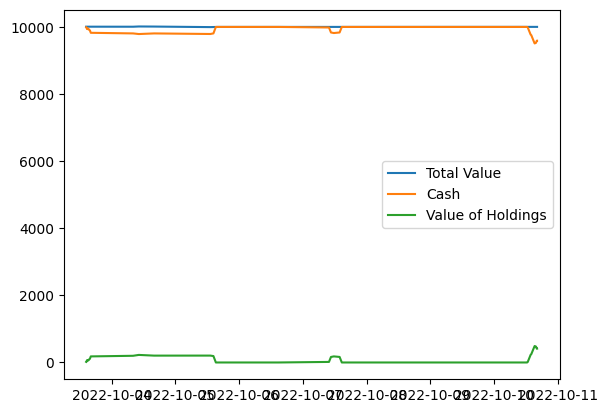

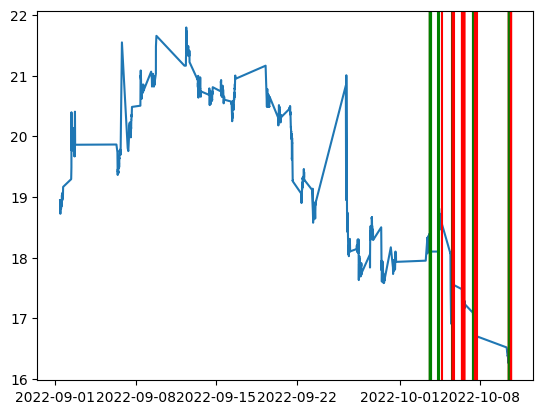

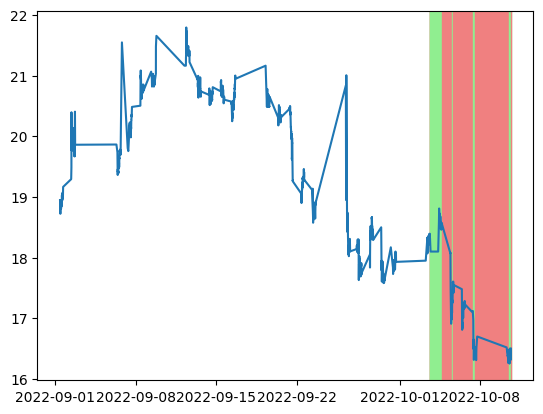

Ticker: BBWI
64 buy/sells performed - 3.046168491194669% of the time
Stock price change: 7.413010590015137%
ROI: 2.8862297226822706%
Relative ROI: 0.3893464993250977%
{'cash': 8452.973000000004, 'assets': 45, 'latest_price': 35.5, 'total_value': 10050.473000000004, 'roi': 0.028862297226822705}


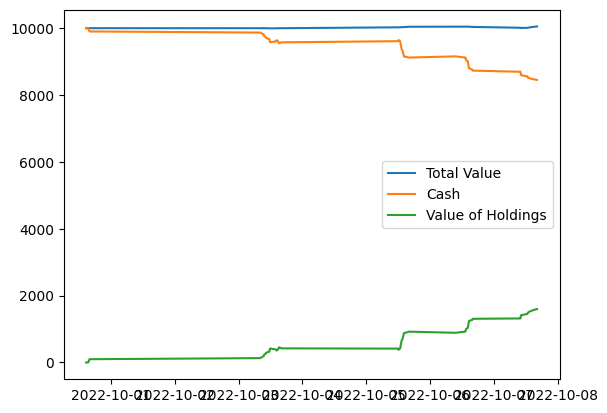

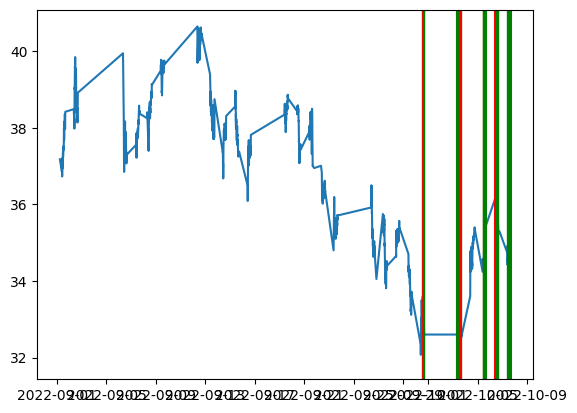

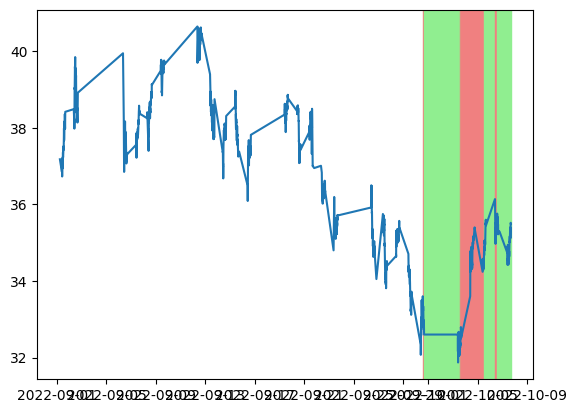

Ticker: DVA
59 buy/sells performed - 2.8474903474903472% of the time
Stock price change: 3.9222699093943802%
ROI: 0.2276230846383324%
Relative ROI: 0.058033508630587496%
{'cash': 6695.0628, 'assets': 38, 'latest_price': 87.17, 'total_value': 10007.522799999999, 'roi': 0.002276230846383324}


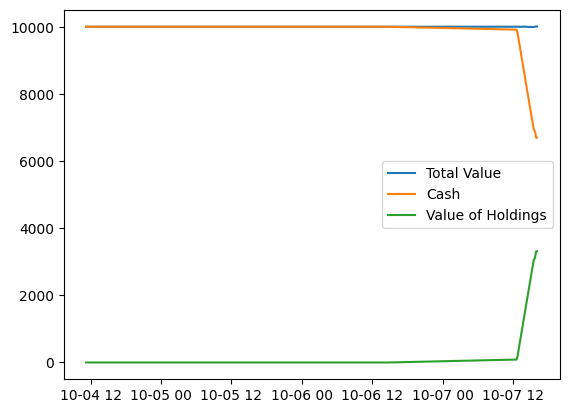

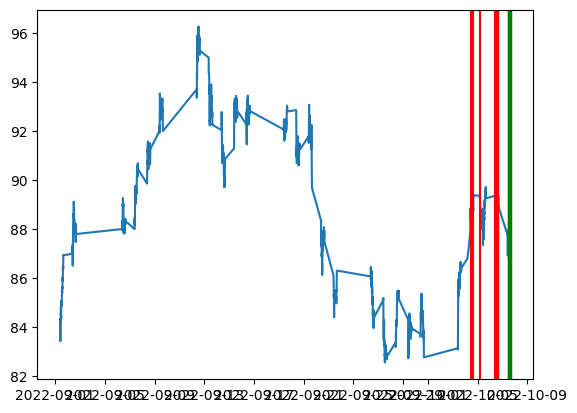

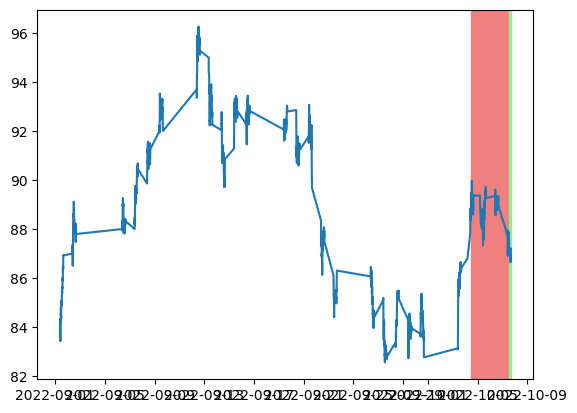

{'average_gainloss': 17.446066666667928,
 'results': {'DEI': {'cash': 9583.342400000001,
   'assets': 25,
   'latest_price': 16.44,
   'total_value': 9994.342400000001,
   'roi': -0.0059851011435122494},
  'BBWI': {'cash': 8452.973000000004,
   'assets': 45,
   'latest_price': 35.5,
   'total_value': 10050.473000000004,
   'roi': 0.028862297226822705},
  'DVA': {'cash': 6695.0628,
   'assets': 38,
   'latest_price': 87.17,
   'total_value': 10007.522799999999,
   'roi': 0.002276230846383324}}}

In [9]:
from model import Model, SklearnBackend
import sklearn.ensemble
import torch

%load_ext autoreload
%reload_ext autoreload
#%autoreload 2
import backtest as bt
from strategy import PretrainedModelStrategy, SignalModelStrategy
from technical_signals import TechnicalSignalSet
from sklearn.svm import SVR


random.shuffle(tickers)
# XXX temporary - need to rework concurrency to be suitable for CUDA
# (Must use `spawn` as opposed to `fork` based concurrency I believe - separate OS processes?)
#net = net.to(torch.device('cpu'))

try:
    del predict
except:
    pass

def predict(net):
    return lambda X:\
        net(torch.from_numpy(X).float().cpu()).detach().numpy()

try:
    del df_to_signal_set
except:
    pass

def df_to_signal_set(df):
    return TechnicalSignalSet(df, predict_window=predict_window)

#strategy = PretrainedModelStrategy(predict(net), df_to_signal_set, cutoff=0.95, bias=0.2)
strategy = PretrainedModelStrategy(predict(model), df_to_signal_set, cutoff=1., bias=0.)
#strategy = SignalModelStrategy(SVR(), lambda df: TechnicalSignalSet(df, predict_window=14), cutoff=1., bias=0.1)
bt.comprehensive_backtest(strategy, tickers[:7], "2022-09-01", "2025-01-01", interval='5min', plot=True, train_test_ratio=0.8)

In [32]:
# Auto reload local files
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
# Make files in src/ available to notebook
import sys
if '../src' not in sys.path:
    sys.path.insert(0, '../src')

import pandas as pd
from datetime import datetime
import signal_library as sl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%%timeit
sl.fetch_signal_set([sl.example2], [], sl.FetchOptions(['AAPL'], (pd.to_datetime("2021-06-01"), datetime.now())))

588 ms ± 29.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit
import datastore as ds
from technical_signals import TechnicalSignalSet

df = ds.get_daily_candlesticks(['AAPL'], pd.to_datetime("2010-06-01"), datetime.now())['AAPL']
TechnicalSignalSet(df, predict_window=30)

/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._trs[0] = diff_directional_movement.dropna()[
/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/ta/trend.py:730: F

302 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/home/jared/.local/share/virtualenvs/stock-prediction-MOS0QyR2/lib/python3.10/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [6]:
len({'hello': 'world'})

1

In [46]:
{1,2,3}.extend([4,5,6])

AttributeError: 'set' object has no attribute 'extend'